# Лабораторная работы №1
## Импортирование библиотек

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima.model import ARIMA

from scipy import stats
from statsmodels.graphics.api import qqplot
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

## Загрузка входных данных

In [2]:
source = pd.read_csv('data/lab1.csv')
X = source["mni108"].dropna()
X

0      7.51
1      6.46
2      6.17
3      8.50
4      9.95
      ...  
79     9.10
80    13.20
81    12.00
82    10.30
83    12.40
Name: mni108, Length: 84, dtype: float64

## График процесса, его АКФ и ЧАКФ

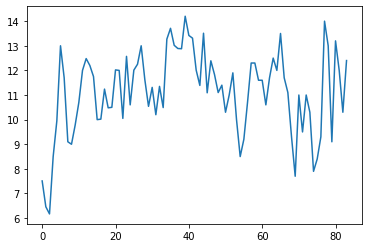

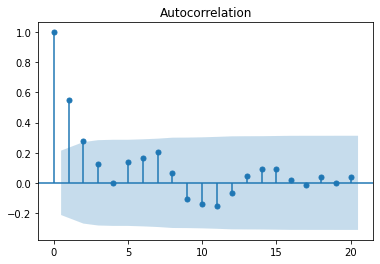

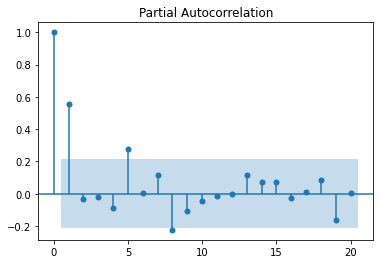

In [4]:
plt.plot(X)
_ = plot_acf(X)
_ = plot_pacf(X)

### Исходя из графиков, максимальный порядок модели - ARMA(3, 2).

### Проведём обучение для всех моделей, порядок которых ниже максимального порядка модели.

Были отброшены модели: 

ARMA(0, 3), ARMA(1, 1), ARMA(1, 2), ARMA(1, 3), ARMA(2, 1), ARMA(2, 2), ARMA(2, 3), ARMA(3, 1), ARMA(3, 0), ARMA(3, 1), ARMA(3, 2), 

так как у данных моделей есть незначимые коэффициенты (pvalues > 0.05)

In [7]:
pOrder  = [0, 1, 2, 3]
qOrder  = [0, 1, 2]
models = {}

for i in pOrder:
    for j in qOrder:
        if ((i, j) == (0, 0)):
            continue
        arma = ARIMA(X_train.to_numpy(), order=(i, 0, j)).fit()
        pVal = arma.pvalues
        if all(i <= 0.05 for i in pVal):
            models[i, j] = arma

### Количество моделей, имеющих значимые коэффициенты, то есть pVal < 0.05

In [8]:
print(f'Количество моделей: {len(models.keys())}')

Количество моделей: 3


## Разделение данных на обучающую и тестовую выборки

In [32]:
split_X = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_X], X.iloc[split_X:]
type(X_train)

pandas.core.series.Series

In [30]:
np.dot(X_train.to_numpy(), X_test.to_numpy())

ValueError: shapes (58,) and (26,) not aligned: 58 (dim 0) != 26 (dim 0)

## Вычисление стандартной ошибки для оставшихся моделей

In [40]:
def standard_error(y, y_1, order):
    return np.sqrt(np.sum(np.square((y_1 - y))) / (len(y) - order))

In [41]:
def standard_error_model(train, test, model):
    k = max(model.model_orders['ar'], model.model_orders['ma'])
    standard_error_train = standard_error(train.to_numpy(), model.predict(0, len(train) - 1), k)
    standard_error_test = standard_error(test.to_numpy(), model.forecast(len(test)), k)
    return standard_error_train, standard_error_test

In [42]:
m = {}

dict_se_train = {}
dict_se_test = {}
dict_aic = {}
dict_bic = {}

for name, model in models.items():
    tmp_dict = {}
    se_train, se_test = standard_error_model(X_train, X_test, model)

    dict_se_train[name] = se_train
    dict_se_test[name] = se_test
    dict_aic[name] = model.aic
    dict_bic[name] = model.bic

    tmp_dict['SE Train'] = se_train
    tmp_dict['SE Test'] = se_test
    tmp_dict['AIC'] = model.aic
    tmp_dict['BIC'] = model.bic
    m[name] = tmp_dict

data = {
    'Model': list(m.keys()),
    'SE Train': list(dict_se_train.values()),
    'SE Test': list(dict_se_test.values()),
    'AIC': list(dict_aic.values()),
    'BIC': list(dict_bic.values())
}

df = pd.DataFrame.from_dict(data)
#diff.set_index('Model')
dfAIC = df.sort_values("AIC")

## Таблица результатов моделей, отсортированных по критерию Акаике

In [43]:
dfAIC.head(10)

,Model,SE Train,SE Test,AIC,BIC
2,"(1, 0)",1.288990,1.688482,195.743418,201.924747
1,"(0, 2)",1.318419,1.740783,199.872486,208.114258
0,"(0, 1)",1.406496,1.709279,207.348146,213.529475


## Анализ остатков моделей

### Для модели ARMA(0, 1) есть коррелированные остатки, поэтому она отбрасывается. 

### Среди моделей ARMA(0, 2) и ARMA(1, 0) наилучшей является ARMA(1, 0), так как у неё критерий Акаике наименьший

ARMA(0, 1)


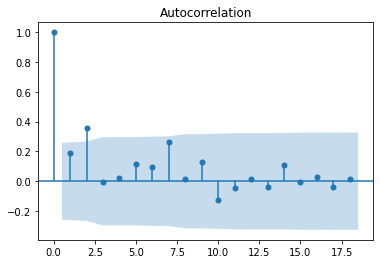

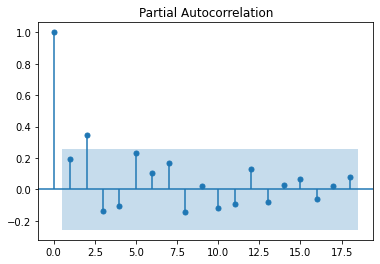

ARMA(0, 2)


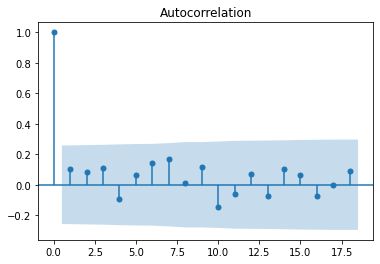

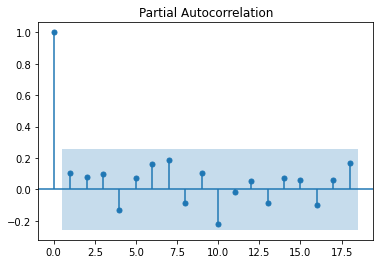

ARMA(1, 0)


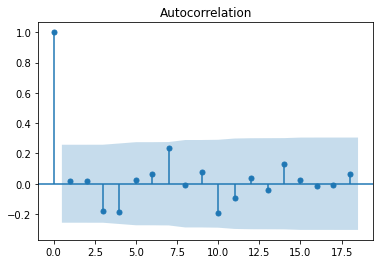

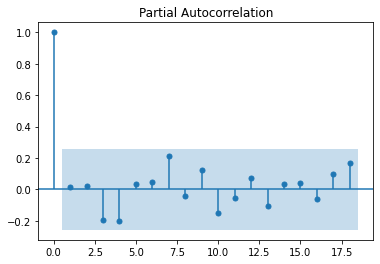

In [44]:
for name, model in models.items():
    print(f'ARMA{name}')
    _ = plot_acf(model.resid)
    _ = plot_pacf(model.resid)
    plt.show()